# SAM-2 segmentor for spheroids

In this Jupyter notebook we go through the whole process of labelling cellular spheroid images using Segment Anything Model 2 for process automation. The resulting labels are saved in YOLO segmentation format for further usage.

In fact, this pipeline can be used as is in Google Colab GPU environment. The only things that will need to be changed are paths to datasets and input point/bbox prompts for the model.

We begin by installing `ultralytics` library which has a convenient high-level wrapper for SAM-2, making its use very quick and simple:

In [ ]:
# Install the Ultralytics package for YOLO object detection
!pip install ultralytics

Next, we import the neccessary libs and define some util functions:

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np  # Required for working with masks and arrays

def convert_polygon_to_yolo_segmentation(xy, orig_shape):
    """
    Converts polygon coordinates into YOLO segmentation format.

    Parameters:
        xy (list of list of tuples): Polygon vertices for masks, where each polygon
                                     is represented as a list of (x, y) tuples.
        orig_shape (tuple): Original image dimensions as (height, width).

    Returns:
        list of list: YOLO segmentation format, where each entry contains the class ID
                      followed by normalized (x, y) coordinates of the polygon vertices.
    """
    img_h, img_w = orig_shape  # Original dimensions of the image
    yolo_data = []

    for mask_coords in xy:
        # Normalize polygon coordinates
        normalized_coords = []
        for x, y in mask_coords:
            norm_x = x / img_w
            norm_y = y / img_h
            normalized_coords.extend([norm_x, norm_y])

        # Add class_id and normalized coordinates to the result
        class_id = 0  # Specify the class ID if necessary
        yolo_data.append([class_id] + normalized_coords)

    return yolo_data


def show_contour(xy, orig_shape):
    """
    Displays a binary mask of the given polygon on the original image dimensions.

    Parameters:
        xy (list of list of tuples): Polygon vertices for masks, where each polygon
                                     is represented as a list of (x, y) tuples.
        orig_shape (tuple): Original image dimensions as (height, width).
    """
    img_h, img_w = orig_shape  # Original dimensions of the image

    for mask in xy:
        # Create an empty binary mask
        binary_mask = np.zeros((img_h, img_w), dtype=np.uint8)

        # Fill the binary mask with the polygon's pixels
        for x, y in mask:
            x = int(x)  # Convert to integer for pixel indexing
            y = int(y)
            binary_mask[y, x] = 255

        # Display the binary mask
        plt.imshow(binary_mask, cmap='gray')
        plt.title("Binary Mask of Polygon")
        plt.axis('off')
        plt.show()

        # Break after displaying the first polygon's mask
        break


Now, we connect our google drive folder to the notebook, get to the ZIPped dataset previously uploaded to our GDrive, and unzip it to the Colab diskspace:

In [ ]:
#Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

#Specify the path to the dataset archive on Google Drive
zip_file_path = '/content/drive/MyDrive/SeqData.zip'

# Step 3: Unzip the file into a directory
import zipfile
import os

# Define the directory where the dataset will be extracted
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Extract the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset successfully extracted to: {extract_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Датасет успешно разархивирован в: /content/dataset


Next, we import some further dependencies, choose a frame sequence to process, and visualize its frames under indices 0 and 1. We also visualize a grid above it to get a better understanding of each pixel's approximate coordinates - this will help us get the coordinates of each spheroid's center which we will further use as point prompts for the SAM model.

According to dataset metadata, frame under index 0 is taken at the beginning of the experiment before injecting the cryoprotector substance to the cell plate; the following frames, starting with frame indexed as 1, are taken after the cryoprotector starts working. This may cause significant spheroid movements around th plate or even may cause some of the spheroids disappear. That is why we create separated sets of point prompts for frame indexed 0 and the other frames (starting with the one indxed as 1) and that is why we visualize both 0th and 1st frames below:

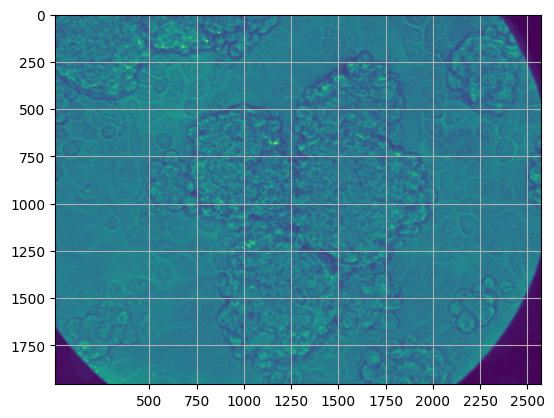

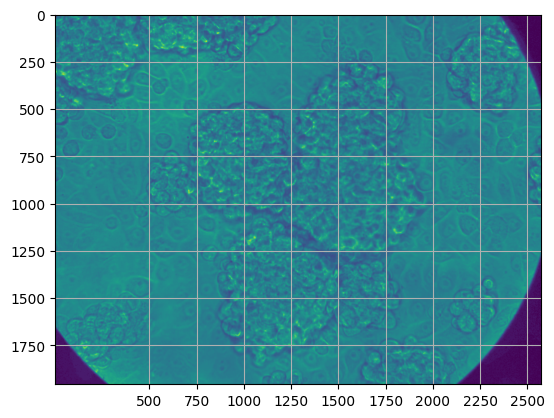

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt  # For visualizing images
import cv2  # For image processing
import numpy as np  # For numerical operations

# Defining folder paths for image data
folder_path = "/content/dataset/SeqData/seq_033"  # Path to the main image sequence folder
mask_folder_path = f"{folder_path}_mask"  # Path to the mask folder (not used in this snippet)
mask_jpg = f"{folder_path}_jpg"  # Path to store JPEG format images (not used in this snippet)

# Reading the first image in the sequence ('t000.jpg') and extracting the first channel (grayscale)
img = cv2.imread(folder_path + "/t000.jpg")[:, :, 0]

# Displaying the first image
plt.imshow(img)  # Visualize the image
plt.xticks(np.arange(500, 2501, 250))  # Set x-axis ticks at intervals from 500 to 2500
plt.grid(True)  # Enable the grid for better visualization
plt.show()  # Display the plot

# Reading the second image in the sequence ('t001.jpg') and extracting the first channel (grayscale)
img = cv2.imread(folder_path + "/t001.jpg")[:, :, 0]

# Displaying the second image
plt.imshow(img)  # Visualize the image
plt.xticks(np.arange(500, 2501, 250))  # Set x-axis ticks at intervals from 500 to 2500
plt.grid(True)  # Enable the grid for better visualization
plt.show()  # Display the plot



Next, we set point coordinates corresponding to each spheroid's center and feed these point prompts to the model along with the image and process the first frame of sequence (indexed as 0). We also create point prompts for the frame indexed as 1, but process the other frames in the next cell. We save the results here and below in YOLO segmentation format (consult ultralytics documentation for more details):

In [ ]:
#t000.jpg

# point=[[500,500],[1250,500],[1300,1300],[1000,1650],[600,1500],[1750,1900]] seq24
# Run inference with bboxes prompt
#point=[[500,500],[500,1500],[2000,1000],[1250,1750]] seq30
#point=[[300,1000],[750, 1500],[1000,1750],[1500,600],[1600,900],[1250,1250]] #seq31
#point=[[500,1250],[1750,500]] #seq39
#point=[[100,250],[1750,1250],[300,1100], [1000, 1750], [2250,1750], [1000,1100],[600,1300],[1250,100]] #seq44
#point=[[600, 1400], [1250, 400], [1750, 750], [600, 900]] #seq45
#point=[[600, 400], [850, 1250], [1400, 650], [1600, 1350], [2300, 850]] #seq46
#point=[[500, 1100], [1600, 1100], [1400, 500], [2200, 150]] # seq47
# point=[[1600, 1350], [1400, 600], [750, 750]] #seq48
# point=[[750, 1750], [700, 1100], [1150, 1250], [1600, 600]] #seq49
# point = [[1250, 850]] #seq50


#t001.jpg

#point=[[100,250], [500,1250],[750,800],[400,600],[1250,1800],[1800,1800],[1600,1400], [1250,800]] seq21
    #point=[[800,750], [1100,300], [1250,1000],[1250,1500],[750,1600],[1300,1950], [1600,500]] seq22
    #point=[[300, 300],[500,1500],[1000,1000], [1300,1600],[1750,1000],[1750,250], [500,1000], [500,100]] seq23
    #point=[[500,500],[750,1500], [1100,1600], [1750,1900]] seq24
    #point=[[500,500],[500,1500],[1500,750],[2000,1250],[2250,500],[2100,100]] seq25
    #point=[[1000,250],[1750,1500],[750,750],[500,1750],[100,500],[2500,300]] seq26
    #point=[[0,250],[600,1100],[750,500],[1250,250],[1350,1000],[2000,500]] #seq27
    #point=[[900,900],[1300,500],[1250,1500]] #seq28
    #point=[[1750,1500],[750,500]] #seq29
    #point=[[500,500],[2000,1000],[2350,750]] #seq30
    #point=[[300,1000],[750, 1500],[1000,1750],[1500,600],[1600,900],[1250,1250],[1750,100]] #seq31
    #point=[[300,1000],[750, 1500],[1000,1750],[1500,500],[2000,1000]] #seq32 погано
    #point=[[100,100],[1250,1500],[1500,1000],[1000, 750],[2250,250],[1800,1900]] #seq 33 так собі на перших 4
    #point=[[750, 250],[1500,500],[1500,1750]] #seq34
    #point=[[750,400],[2000,250],[2000,1500],[500,1000],[1250,1300], [100,500]] #seq35
    #point=[[100,250],[500,1750],[1500,500],[1500,1250],[2250,500],[2500,1100]] #seq36
    #point=[[750,750],[800,1300],[1250,1000],[1800,500],[2000,1250]] #seq37
    #point=[[750,250],[500,1500],[1750,1750]] #seq38
    #point=[[1750,500],[1750,1250]] #seq39
    #point=[[1250,750]] #seq40
    #point=[[1000,1250],[1900,1000]] #seq41
    #point=[[1250,500],[1250,1250],[1800,800],[2000, 1250], [750,500],[600,800]] #seq42
    #point=[[1500,750],[750,1250]] #seq43
    #point=[[100,250],[1750,1250],[300,1100], [1000, 1750], [2250,1750], [1000,1100],[600,1300],[1250,100]] #seq44
    #point=[[600, 1400], [1250, 400], [1750, 750]] #seq45
    #point=[[600, 400], [850, 1250], [1400, 650], [1600, 1350], [2300, 850]] #seq46
    #point=[[500, 1100], [1600, 1100], [1400, 500], [2200, 150]] # seq47
    # point=[[1400, 600], [750, 750]] #seq48
    # point=[[750, 1750], [700, 1100], [1150, 1250]] #seq49
    # point = [[1250, 850]] #seq50
    # point = [[1400, 650], [1250, 1500]] #seq51
    # point = [[1250, 850]] #seq52
    # point = [[1250, 850]] #seq53
    # point = [ [1150, 1400],[1400, 350]] #seq54
    # point = [[1000, 750]] #seq55
    # point = [[750, 1250], [1150, 700], [1400, 350]] #seq56
    # point = [[850, 850], [1650, 850]] #seq57
    # point = [[450, 600], [1100, 600], [1750, 900], [1250, 1600]] #seq58

In [ ]:
# Importing required libraries
from ultralytics import SAM  # For segment anything model (SAM)
import os  # For filesystem operations
import shutil  # For handling file and directory operations
import numpy as np  # For numerical operations

# Load the pre-trained SAM model
model = SAM("sam2_l.pt")

# Display model information (optional, useful for debugging)
model.info()

# Remove existing mask folder if it exists to ensure a clean state
if os.path.exists(mask_folder_path):
    shutil.rmtree(mask_folder_path)  # Remove the mask folder and its contents

# Remove existing folder for JPEG masks if it exists
if os.path.exists(mask_jpg):
    shutil.rmtree(mask_jpg)  # Remove the JPEG folder and its contents

# Create new folders for storing masks and JPEG outputs
os.makedirs(mask_folder_path, exist_ok=True)  # Create the mask folder if it doesn't exist
os.makedirs(mask_jpg, exist_ok=True)  # Create the JPEG folder if it doesn't exist

# Process an image with SAM to generate masks
# `points` should be a list of points used for segmentation
# `labels` is an array of ones indicating foreground points
results = model(folder_path + "/t000.jpg", points=point, labels=np.ones((len(point),)))  # You can set imgsz if resizing is needed

# Save the resulting mask as a JPEG file
output_path = os.path.join(mask_jpg, "t000.jpg")  # Define the path to save the JPEG mask
results[0].save(output_path)  # Save the first result as a JPEG

# Extract mask data from the results
masks_data = results[0].masks  # Get mask details such as polygons and shapes

# Convert polygons to YOLO segmentation format
# The function `convert_polygon_to_yolo_segmentation` should handle this transformation
yolo_annotations = convert_polygon_to_yolo_segmentation(masks_data.xy, masks_data.orig_shape)

# Save YOLO annotations to a text file
txt_output_path = os.path.join(mask_folder_path, "t000.txt")  # Define the output path for annotations
with open(txt_output_path, "w") as f:
    for annotation in yolo_annotations:
        f.write(" ".join(map(str, annotation)) + "\n")  # Write annotations line by line


Model summary: 854 layers, 224,430,130 parameters, 224,430,130 gradients

image 1/1 /content/dataset/SeqData/seq_033/t000.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 771.1ms
Speed: 10.8ms preprocess, 771.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


Next, we set point coordinates corresponding to each spheroid's center and feed these point prompts to the model along with the image and process our frame sequence frame-by-frame starting from the frame indexed as 1 using the same point prompts as for the frame under index 1:

In [ ]:

from tqdm import tqdm  # For progress bar visualization

# Get a sorted list of image files (JPEG and PNG) in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])

# Iterate through all image files, starting from the second image (skipping the first)
for image_file in tqdm(image_files[1:], desc="Processing Images"):
    # Full path to the current image
    image_path = os.path.join(folder_path, image_file)

    # Run SAM model inference with bounding boxes or point prompts
    # `points` is a list of points for segmentation
    # `labels` indicates foreground or background for each point
    results = model(image_path, points=point, labels=np.ones((len(point),)))  # Optionally set imgsz for resizing

    # Save the mask output as a JPEG file
    output_path = os.path.join(mask_jpg, f"{os.path.splitext(image_file)[0]}.jpg")  # Define the output JPEG path
    results[0].save(output_path)  # Save the first result (mask) as a JPEG image

    # Extract mask data from the results
    masks_data = results[0].masks  # Access masks, including polygon data

    # Convert polygons to YOLO segmentation format
    # Ensure `convert_polygon_to_yolo_segmentation` is implemented for this purpose
    yolo_annotations = convert_polygon_to_yolo_segmentation(masks_data.xy, masks_data.orig_shape)

    # Save YOLO annotations to a text file
    txt_output_path = os.path.join(mask_folder_path, f"{os.path.splitext(image_file)[0]}.txt")  # Define annotation file path
    with open(txt_output_path, "w") as f:
        # Write each annotation in YOLO format
        for annotation in yolo_annotations:
            f.write(" ".join(map(str, annotation)) + "\n")




  0%|          | 0/40 [00:00<?, ?it/s]


image 1/1 /content/dataset/SeqData/seq_033/t001.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 712.6ms
Speed: 11.5ms preprocess, 712.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


  2%|▎         | 1/40 [00:01<00:48,  1.24s/it]


image 1/1 /content/dataset/SeqData/seq_033/t002.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 710.5ms
Speed: 10.4ms preprocess, 710.5ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)


  5%|▌         | 2/40 [00:02<00:42,  1.13s/it]


image 1/1 /content/dataset/SeqData/seq_033/t003.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 684.2ms
Speed: 7.2ms preprocess, 684.2ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)


  8%|▊         | 3/40 [00:03<00:39,  1.07s/it]


image 1/1 /content/dataset/SeqData/seq_033/t004.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 684.5ms
Speed: 10.2ms preprocess, 684.5ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 10%|█         | 4/40 [00:04<00:35,  1.00it/s]


image 1/1 /content/dataset/SeqData/seq_033/t005.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 690.0ms
Speed: 6.6ms preprocess, 690.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)


 12%|█▎        | 5/40 [00:05<00:33,  1.05it/s]


image 1/1 /content/dataset/SeqData/seq_033/t006.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 692.3ms
Speed: 6.7ms preprocess, 692.3ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 15%|█▌        | 6/40 [00:05<00:31,  1.08it/s]


image 1/1 /content/dataset/SeqData/seq_033/t007.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 695.3ms
Speed: 7.9ms preprocess, 695.3ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 18%|█▊        | 7/40 [00:06<00:30,  1.09it/s]


image 1/1 /content/dataset/SeqData/seq_033/t008.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 699.7ms
Speed: 6.8ms preprocess, 699.7ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 20%|██        | 8/40 [00:07<00:28,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t009.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 699.9ms
Speed: 6.9ms preprocess, 699.9ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 22%|██▎       | 9/40 [00:08<00:27,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t010.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 699.7ms
Speed: 7.9ms preprocess, 699.7ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 25%|██▌       | 10/40 [00:09<00:26,  1.12it/s]


image 1/1 /content/dataset/SeqData/seq_033/t011.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 704.1ms
Speed: 7.0ms preprocess, 704.1ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 28%|██▊       | 11/40 [00:10<00:25,  1.12it/s]


image 1/1 /content/dataset/SeqData/seq_033/t012.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 703.7ms
Speed: 6.7ms preprocess, 703.7ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 30%|███       | 12/40 [00:11<00:25,  1.12it/s]


image 1/1 /content/dataset/SeqData/seq_033/t013.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 723.3ms
Speed: 6.9ms preprocess, 723.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


 32%|███▎      | 13/40 [00:12<00:24,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t014.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 713.6ms
Speed: 7.0ms preprocess, 713.6ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 35%|███▌      | 14/40 [00:13<00:23,  1.09it/s]


image 1/1 /content/dataset/SeqData/seq_033/t015.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 712.4ms
Speed: 10.9ms preprocess, 712.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 38%|███▊      | 15/40 [00:14<00:23,  1.08it/s]


image 1/1 /content/dataset/SeqData/seq_033/t016.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 714.4ms
Speed: 14.0ms preprocess, 714.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 40%|████      | 16/40 [00:15<00:22,  1.06it/s]


image 1/1 /content/dataset/SeqData/seq_033/t017.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 714.4ms
Speed: 11.0ms preprocess, 714.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 42%|████▎     | 17/40 [00:16<00:21,  1.06it/s]


image 1/1 /content/dataset/SeqData/seq_033/t018.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 696.4ms
Speed: 10.6ms preprocess, 696.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 45%|████▌     | 18/40 [00:16<00:20,  1.08it/s]


image 1/1 /content/dataset/SeqData/seq_033/t019.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 714.6ms
Speed: 6.6ms preprocess, 714.6ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 48%|████▊     | 19/40 [00:17<00:19,  1.09it/s]


image 1/1 /content/dataset/SeqData/seq_033/t020.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 717.1ms
Speed: 6.7ms preprocess, 717.1ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 50%|█████     | 20/40 [00:18<00:18,  1.09it/s]


image 1/1 /content/dataset/SeqData/seq_033/t021.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 712.5ms
Speed: 6.7ms preprocess, 712.5ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 52%|█████▎    | 21/40 [00:19<00:17,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t022.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 715.1ms
Speed: 6.8ms preprocess, 715.1ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 55%|█████▌    | 22/40 [00:20<00:16,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t023.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 710.5ms
Speed: 6.9ms preprocess, 710.5ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 57%|█████▊    | 23/40 [00:21<00:15,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t024.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 709.6ms
Speed: 6.7ms preprocess, 709.6ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 60%|██████    | 24/40 [00:22<00:14,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t025.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 708.4ms
Speed: 6.7ms preprocess, 708.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 62%|██████▎   | 25/40 [00:23<00:13,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t026.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 706.8ms
Speed: 7.0ms preprocess, 706.8ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 65%|██████▌   | 26/40 [00:24<00:12,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t027.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 699.9ms
Speed: 6.9ms preprocess, 699.9ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 68%|██████▊   | 27/40 [00:25<00:11,  1.11it/s]


image 1/1 /content/dataset/SeqData/seq_033/t028.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 695.0ms
Speed: 6.5ms preprocess, 695.0ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 70%|███████   | 28/40 [00:25<00:10,  1.12it/s]


image 1/1 /content/dataset/SeqData/seq_033/t029.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 696.1ms
Speed: 6.9ms preprocess, 696.1ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 72%|███████▎  | 29/40 [00:26<00:09,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t030.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 696.0ms
Speed: 12.2ms preprocess, 696.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)


 75%|███████▌  | 30/40 [00:27<00:09,  1.08it/s]


image 1/1 /content/dataset/SeqData/seq_033/t031.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 697.0ms
Speed: 10.7ms preprocess, 697.0ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 78%|███████▊  | 31/40 [00:28<00:08,  1.08it/s]


image 1/1 /content/dataset/SeqData/seq_033/t032.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 691.2ms
Speed: 12.1ms preprocess, 691.2ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 80%|████████  | 32/40 [00:29<00:07,  1.07it/s]


image 1/1 /content/dataset/SeqData/seq_033/t033.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 687.4ms
Speed: 10.1ms preprocess, 687.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


 82%|████████▎ | 33/40 [00:30<00:06,  1.09it/s]


image 1/1 /content/dataset/SeqData/seq_033/t034.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 682.8ms
Speed: 6.8ms preprocess, 682.8ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 85%|████████▌ | 34/40 [00:31<00:05,  1.10it/s]


image 1/1 /content/dataset/SeqData/seq_033/t035.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 671.9ms
Speed: 6.7ms preprocess, 671.9ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 88%|████████▊ | 35/40 [00:32<00:04,  1.12it/s]


image 1/1 /content/dataset/SeqData/seq_033/t036.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 682.6ms
Speed: 6.7ms preprocess, 682.6ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 90%|█████████ | 36/40 [00:33<00:03,  1.13it/s]


image 1/1 /content/dataset/SeqData/seq_033/t037.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 680.2ms
Speed: 7.0ms preprocess, 680.2ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 92%|█████████▎| 37/40 [00:34<00:02,  1.14it/s]


image 1/1 /content/dataset/SeqData/seq_033/t038.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 675.4ms
Speed: 6.8ms preprocess, 675.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 95%|█████████▌| 38/40 [00:34<00:01,  1.14it/s]


image 1/1 /content/dataset/SeqData/seq_033/t039.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 674.8ms
Speed: 6.6ms preprocess, 674.8ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


 98%|█████████▊| 39/40 [00:35<00:00,  1.15it/s]


image 1/1 /content/dataset/SeqData/seq_033/t040.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 672.4ms
Speed: 9.5ms preprocess, 672.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


We finally archive the obtained labels

In [ ]:
# Creating a compressed tarball for the mask folder
# The output will be 'seq_033_mask.tar.gz' stored in the '/content/dataset' directory
!tar -cvf /content/dataset/seq_033_mask.tar.gz /content/dataset/SeqData/seq_033_mask

# Creating a compressed tarball for the JPEG mask folder
# The output will be 'seq_033_jpg.tar.gz' stored in the '/content/dataset' directory
!tar -cvf /content/dataset/seq_033_jpg.tar.gz /content/dataset/SeqData/seq_033_jpg


tar: Removing leading `/' from member names
/content/dataset/SeqData/seq_033_mask/
/content/dataset/SeqData/seq_033_mask/t008.txt
/content/dataset/SeqData/seq_033_mask/t036.txt
/content/dataset/SeqData/seq_033_mask/t022.txt
/content/dataset/SeqData/seq_033_mask/t025.txt
/content/dataset/SeqData/seq_033_mask/t038.txt
/content/dataset/SeqData/seq_033_mask/t006.txt
/content/dataset/SeqData/seq_033_mask/t005.txt
/content/dataset/SeqData/seq_033_mask/t023.txt
/content/dataset/SeqData/seq_033_mask/t017.txt
/content/dataset/SeqData/seq_033_mask/t039.txt
/content/dataset/SeqData/seq_033_mask/t009.txt
/content/dataset/SeqData/seq_033_mask/t004.txt
/content/dataset/SeqData/seq_033_mask/t034.txt
/content/dataset/SeqData/seq_033_mask/t030.txt
/content/dataset/SeqData/seq_033_mask/t014.txt
/content/dataset/SeqData/seq_033_mask/t021.txt
/content/dataset/SeqData/seq_033_mask/t016.txt
/content/dataset/SeqData/seq_033_mask/t029.txt
/content/dataset/SeqData/seq_033_mask/t010.txt
/content/dataset/SeqData

By changing paths to frame sequence folders and the point (bbox) prompts, we can process all the sequences one by one. In case point prompts do not lead to satisfactory outcomes, it is worth trying bbox prompts (see ultralytics documentation on SAM/SAM-2 for more details) as they usually lead to better model's behaviour. If the model still fails, however, the sequence will have to be either labelled manually (e.g., using CVAT) or left aside (ignored) as its quality may not be good enough.